# Лабораторная работа №5

Борисов Дмитрий Сергеевич (Вар. 5)
## Assignment

Perform clustering for data of your variant using K-Means and its 'soft' version. Find the number of clusters that yields the highest _purity_, use different distance metrics: euclidean distance, manhattan distance, сhebyshev distance. Plot the graphs of purity and DBI values depending on the `K` (number of clusters) for each of the distance metrics.

### Upon the completion of the assignment, the following must be done

1. DataFrame with purity and DBI for each distance metric for the best `K` parameter.
2. Figures show the relationship between the purity and `K`, DBI and `K`.
3. Visualize clustering result of your best model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.cluster import contingency_matrix

## Getting data
---
## Получение данных

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = np.load('/content/drive/MyDrive/Data_for_labs/AIML_var5.npy')
mask = np.load('/content/drive/MyDrive/Data_for_labs/AIML_var5_mask.npy')

In [4]:
data.shape, mask.shape

((512, 512, 237), (512, 512))

In [5]:
height = data.shape[0]
width = data.shape[1]
ordered_positions = np.array(np.meshgrid(np.arange(height), np.arange(width))).T.reshape(-1, 2)

In [6]:
indices = shuffle(ordered_positions, random_state=0)

In [7]:
X = []
Y = []

In [8]:
for idx in indices:
    X.append(data[idx[0], idx[1], ::])
    Y.append(mask[idx[0], idx[1]])    
     
X = np.array(X, copy=False)
Y = np.array(Y, copy=False)

In [9]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [10]:
X.shape, Y.shape

((262144, 237), (262144,))

## Functions for data visualization

---

## Функции для визуализации данных

In [11]:
def plot_colored_points(X, colors, title=None):
    fig = plt.figure()
    fig.set_size_inches(14, 7)
    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    axes.scatter(X[:,0], X[:,1], c=colors)
    if title is not None:
      axes.set_title(title)


def plot_cost(cost):
    fig = plt.figure()
    fig.set_size_inches(14, 7)
    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    axes.plot(cost)

## Distance calculation functions
---
## Функции вычисления расстояния

euclidean, chebyshev, manhattan

In [12]:
from time import time 
from scipy.spatial.distance import euclidean, chebyshev, cityblock

In [13]:
def my_euclidean(x, y):
    """
    Calculating the Euclidean distance.
    """
    diff = x - y
    return np.sqrt(np.sum(diff * diff, axis=-1))

In [14]:
def my_manhattan(x, y):
    """
    Calculating the Manhattan distance.
    """
    return np.sum(np.abs(x - y), axis=-1)

In [15]:
def my_chebyshev(x, y):
    """
    Calculating the Chebyshev distance.
    """
    return np.abs(x - y).max(axis=-1)  

In [16]:
def compare_scipy_and_my_functions(x, y, scipy_f, my_f, title, repeats=10000):
  start = time()
  for _ in range(repeats):
    scipy_res = scipy_f(x, y)
  scipy_time = (time() - start) / repeats

  start = time()
  for _ in range(repeats):
    my_res = my_f(x, y)
  my_time = (time() - start) / repeats

  print(f"----------{title}----------")
  print(f"scipy time: {scipy_time}")
  print(f"my time: {my_time}")
  print(f"scipy res: {scipy_res}")
  print(f"my res: {my_res}")

In [17]:
x, y = np.random.randn(1000), np.random.randn(1000)

In [18]:
compare_scipy_and_my_functions(x, y, euclidean, my_euclidean, "Euclidean distance")
compare_scipy_and_my_functions(x, y, cityblock, my_manhattan, "Manhattan distance")
compare_scipy_and_my_functions(x, y, chebyshev, my_chebyshev, "Chebyshev distance")

----------Euclidean distance----------
scipy time: 3.122959136962891e-05
my time: 2.8386712074279785e-05
scipy res: 45.20913441556451
my res: 45.20913441556451
----------Manhattan distance----------
scipy time: 3.677740097045898e-05
my time: 2.4577999114990233e-05
scipy res: 1141.9864755276167
my res: 1141.9864755276167
----------Chebyshev distance----------
scipy time: 0.00015641548633575438
my time: 5.862212181091309e-06
scipy res: 5.348919266444038
my res: 5.348919266444038


Вывод: мои функции вычисления расстояния немного быстрее, буду использовать их в данной работе.

## K-Means implementation

In [19]:
def k_means(X, K, max_iter=20, distance=my_euclidean, plotting=True):
    # N - number of samples, D - dimensionality (number of features)
    # N - число объектов выборки, D - размерность (число признаков)
    N, D = X.shape
    # Labels
    # Метки
    L = np.zeros(N)
    # Cluster centers
    # Центры кластеров
    M = np.zeros((K, D))
    
    # Randomly initialize the centers of clusters (step 1)
    # Случайная инициализация центров кластеров (шаг 1)
    for k in range(K):
        M[k] = X[np.random.choice(N)]
    
    M_prev = M.copy()
    for i in range(max_iter):
        dists = []
        # Calculate distances from each point to each cluster.
        # Вычисляет расстрояние от каджой точки до каждого кластера
        for k in range(K):
            dists += [distance(X, M[k]).reshape(-1, 1)]
        # dists has shape (K, N, 1)
        # dists имеет следующие размеры (K, N, 1)
        dists = np.hstack(dists) # (K, N, 1) -> (N, K)
        # Find the closest cluster for each point (step 2)
        # Найдем ближайший кластер для каждой точки (шаг 2)
        L = np.argmin(dists, axis=1)
        # Recalculate cluster centers (шаг 3)
        # Пересчитаем центры кластеров (шаг 3)
        for k in range(K):
            M[k] = X[L==k].mean(axis=0)
            
        # Check convergence condition
        # Проверим условие сходимости
        if np.allclose(M, M_prev):
            print(f'KMeans with {K} clusters converged on {i}th iteration')
            break
        else:
            M_prev = M.copy()
    
    if plotting:
      plot_colored_points(X, L)
    return M, L

## Soft K-Means

In [20]:
def cluster_resp(distances):
    """
    Function for the calculation of the cluster responsibilities
        
    Larger the distance to cluster `k` - less important the point for the cluster `k`
    Note that this is very similar to the `softmax` function.
    
    Softmax function: https://en.wikipedia.org/wiki/Softmax_function
    
    ---
    
    Функция для вычисления значения принадлежности точек кластерам.
    
    Чем больше расстояние до кластер "к" - тем менее важна данная точка для кластера "к"
    Обратите внимание, данная функция очень похожа на функцию "softmax"
    
    Softmax функция: https://ru.wikipedia.org/wiki/Softmax
    
    """
    d_exp = np.exp(-distances)
    return d_exp / np.sum(d_exp, axis=1, keepdims=True)

In [21]:
def loss(X, M, R, distance=my_euclidean):
    """
    Another way of measuring the quality of the clustering results.
    Try to deduce the meaning of this `loss` on your own.
    This measure can be used as a criteria for stopping the algorithm.
    
    ---
    
    Другой способ измерения качества результатов кластеризации
    Постарайтесь самостоятельно понять значение этой функции
    Эта метрика может быть использована в качестве критерия остановки алгоритма
    """
    loss = 0
    for k in range(len(M)):
        d = distance(X, M[k])
        loss += np.sum(R[:,k] * (d * d))
    return loss

In [22]:
def soft_k_means(X, K, max_iter=20, distance=my_euclidean, plotting=True):
    # N - number of samples, D - dimensionality (number of features)
    # N - число объектов выборки, D - размерность (число признаков)
    N, D = X.shape
    # Responsibility matrix.
    # R[i, j] = probability that point `i` belongs to cluster `j` 
    # or responsibility of the cluster `j` for the point `i`.
    # Матрица принадлежности.
    # R[i, j] = вероятность того что `i` точка принадлежит кластеру `j`
    # или пренадлежность кластера `j` точке `i`
    R = np.zeros((N, K))
    # Cluster centers
    # Центры кластеров
    M = np.zeros((K, D))
    
    # Loss array
    # Массив значений ошибок
    losses = []
    
    # Randomly initialize the centers (step 1)
    # Случайная инициализация центров кластеров (шаг 1)
    for k in range(K):
        M[k] = X[np.random.choice(N)]
    
    for i in range(max_iter):
        dists = []
        # Calculate distances from each point to each cluster.
        # Вычисляет расстрояние от каджой точки до каждого кластера
        for k in range(K):
            dists += [distance(X, M[k]).reshape(-1, 1)]
        # dists has shape (K, N, 1)
        # dists имеет следующие размеры (K, N, 1)
        dists = np.hstack(dists) # (K, N, 1) -> (N, K)
        
        # Calculate cluster responsibilities (step 2)
        # Вычислим значения принадлежностей точек кластерам (шаг 2)
        R = cluster_resp(dists)
        
        # Recalculate cluster centers (step 3)
        # Пересчитаем центры кластеров (шаг 3)
        for k in range(K):
            M[k] = R[:,k].dot(X) / R[:,k].sum()
            
        losses.append(loss(X, M, R, distance))
            
        # Check convergence condition
        # Проверим условие сходимости
        if len(losses) > 2 and np.abs(losses[-1] - losses[-2]) < 1e-6:
            print(f'Soft KMeans with {K} clusters converged on {i}th iteration')
            break
        
    if plotting:
      plot_cost(losses)
      colors = np.random.random((K,3))
      p_colors = R.dot(colors)
      plot_colored_points(X, p_colors)
    return M, R, losses

## Clustering evaluation metrics
---
## Метрики оценки кластеризации

In our case we will use the [purity](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html) as __external__ metric.

---

В данной работе будем использовать [purity](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html) в качестве __внешней__ метрики.

In [23]:
# External evaluation
def metrics_purity(class_labels, cluster_labels):
    """
    Compute the purity metric for evaluation of clustering.
    
    Parameters
    ----------
    class_labels : ndarray
        Contains true labels. Shape [n_points].
    cluster_labels : ndarray
        Contains clustering labels. Shape [n_points].
        
    Returns
    -------
    float
        Purity metric 
    """
    
    c_m = contingency_matrix(class_labels, cluster_labels)
    return np.sum(np.amax(c_m, axis=0)) / np.sum(c_m)

In our case we will use the [Davies-Bouldin Index](https://scikit-learn.org/stable/modules/clustering.html#davies-bouldin-index) as __internal__ metric.

---

В данной работе будем использовать [Davies-Bouldin Index (Индекс Дэвиса-Болдина)](https://scikit-learn.org/stable/modules/clustering.html#davies-bouldin-index) в качестве __внутренней__ метрики.

In [24]:
# Internal evaluation
def metrics_davies_bouldin(X, cluster_labels, distance=my_euclidean):
    """
    Computes Davies Bouldin Index.
    
    Parameters
    ----------
    X : ndarray
        Data points. Shape [n_points, num_features].
    cluster_labels : ndarray
        Contains clustering labels. Shape [n_points].
    distance : function
        Python function with API: distance(vector_a, vector_b) -> float.
    
    Returns
    -------
    float
        Davies Bouldin Index.
    """
    n_cluster = len(np.bincount(cluster_labels))
    cluster_k = [X[cluster_labels == k] for k in range(n_cluster)]
    centroids = [np.mean(k, axis = 0) for k in cluster_k]
    variances = [np.mean([distance(p, centroids[i]) for p in k]) for i, k in enumerate(cluster_k)]
    db = []
    eps = 0.000001

    for i in range(n_cluster):
        for j in range(n_cluster):
            if j != i:
                db.append((variances[i] + variances[j]) / (distance(centroids[i], centroids[j]) + eps))

    return(np.max(db) / n_cluster)

## Start of calculations
---
## Начало вычислений

In [25]:
unique_labels = np.unique(Y)
unique_labels

array([0, 4, 5, 7], dtype=uint8)

In [26]:
n_clusters = range(2, len(unique_labels) + 1)
max_iter = 100
distances = ["Euclidean distance", "Manhattan distance", "Chebyshev distance"]
my_functions = [my_euclidean, my_manhattan, my_chebyshev]
result_dfs = { 
    "K-Means results": pd.DataFrame(None, index=n_clusters, columns=distances),
    "Soft K-Means results": pd.DataFrame(None, index=n_clusters, columns=distances)
    }
purity_dfs = { 
    "K-Means purity": pd.DataFrame(0, index=n_clusters, columns=distances),
    "Soft K-Means purity": pd.DataFrame(0, index=n_clusters, columns=distances)
    }
DBI_dfs = { 
    "K-Means DBI": pd.DataFrame(0, index=n_clusters, columns=distances),
    "Soft K-Means DBI": pd.DataFrame(0, index=n_clusters, columns=distances)
    }

In [27]:
for clusters in n_clusters:
  for func, dist in zip(my_functions, distances):
    M, L = k_means(X, clusters, max_iter, func, plotting=False)
    result_dfs["K-Means results"].loc[clusters, dist] = np.array([M, L], dtype=object)
    purity_dfs["K-Means purity"].loc[clusters, dist] = metrics_purity(Y, L)
    DBI_dfs["K-Means DBI"].loc[clusters, dist] = metrics_davies_bouldin(X, L, distance=func)

    M, R, losses = soft_k_means(X, clusters, max_iter, func, plotting=False)
    result_dfs["Soft K-Means results"].loc[clusters, dist] = np.array([M, R, losses], dtype=object)
    L = np.argmax(R, axis=1)
    purity_dfs["Soft K-Means purity"].loc[clusters, dist] = metrics_purity(Y, L)
    DBI_dfs["Soft K-Means DBI"].loc[clusters, dist] = metrics_davies_bouldin(X, L, distance=func)

KMeans with 2 clusters converged on 21th iteration
Soft KMeans with 2 clusters converged on 33th iteration
KMeans with 2 clusters converged on 16th iteration
Soft KMeans with 2 clusters converged on 47th iteration
KMeans with 2 clusters converged on 19th iteration
Soft KMeans with 2 clusters converged on 7th iteration
KMeans with 3 clusters converged on 54th iteration
KMeans with 3 clusters converged on 38th iteration
KMeans with 3 clusters converged on 38th iteration
Soft KMeans with 3 clusters converged on 7th iteration


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KMeans with 4 clusters converged on 99th iteration
KMeans with 4 clusters converged on 72th iteration
Soft KMeans with 4 clusters converged on 7th iteration


## Visualisation fo results
---
## Визуализация результатов

In [28]:
print(purity_dfs["K-Means purity"])
print(purity_dfs["Soft K-Means purity"])

   Euclidean distance  Manhattan distance  Chebyshev distance
2            0.503517            0.503517            0.503517
3            0.503517            0.503517            0.511726
4            0.534931            0.536461            0.532856
   Euclidean distance  Manhattan distance  Chebyshev distance
2            0.503517            0.503517            0.503517
3            0.503517            0.503517            0.503517
4            0.503517            0.534637            0.503517


In [29]:
print(DBI_dfs["K-Means DBI"])
print(DBI_dfs["Soft K-Means DBI"])

   Euclidean distance  Manhattan distance  Chebyshev distance
2            0.396707            0.367799            0.473443
3            0.313044            0.328061            0.352795
4            0.252176            0.272068            0.309737
   Euclidean distance  Manhattan distance  Chebyshev distance
2            0.396992            0.367788            0.493231
3            0.332612            0.328111                 NaN
4            0.317063            0.278315                 NaN


### 1. DataFrame with purity and DBI for each distance metric for the best `K` parameter.

best `K` parameter is __4__

In [30]:
best_kmeans_purity_for_best_K = purity_dfs["K-Means purity"].max()
best_soft_kmeans_purity_for_best_K = purity_dfs["Soft K-Means purity"].max()
print(best_kmeans_purity_for_best_K) 
print(best_soft_kmeans_purity_for_best_K)

Euclidean distance    0.534931
Manhattan distance    0.536461
Chebyshev distance    0.532856
dtype: float64
Euclidean distance    0.503517
Manhattan distance    0.534637
Chebyshev distance    0.503517
dtype: float64


### 2. Figures show the relationship between the purity and `K`, DBI and `K`.

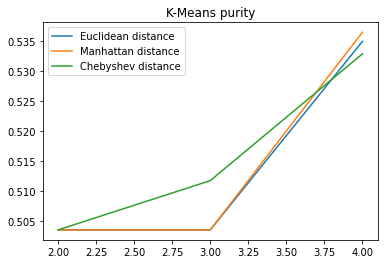

In [49]:
purity_dfs["K-Means purity"].plot(title="K-Means purity")

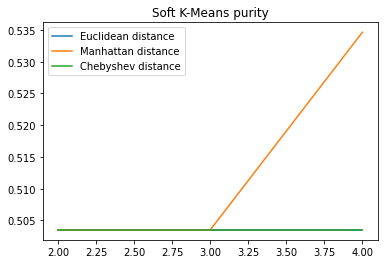

In [50]:
purity_dfs["Soft K-Means purity"].plot(title="Soft K-Means purity")

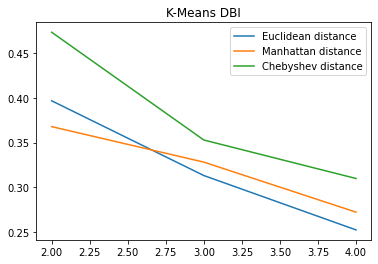

In [51]:
DBI_dfs["K-Means DBI"].plot(title="K-Means DBI")

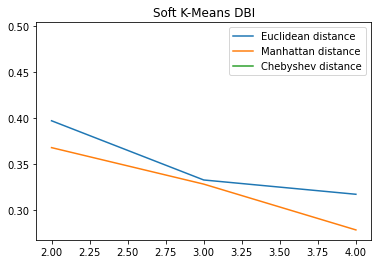

In [52]:
DBI_dfs["Soft K-Means DBI"].plot(title="Soft K-Means DBI")

### 3. Visualize clustering result of your best model.

Best __K-Mean__ model for __euclidean__ distance

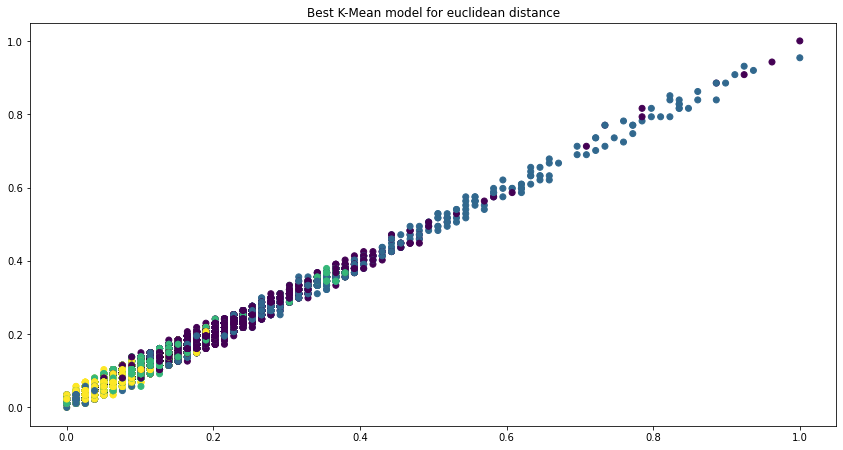

In [55]:
_, L = result_dfs["K-Means results"].loc[4, "Euclidean distance"]
plot_colored_points(X, L, title="Best K-Mean model for euclidean distance")

Best __K-Mean__ model for __manhattan__ distance

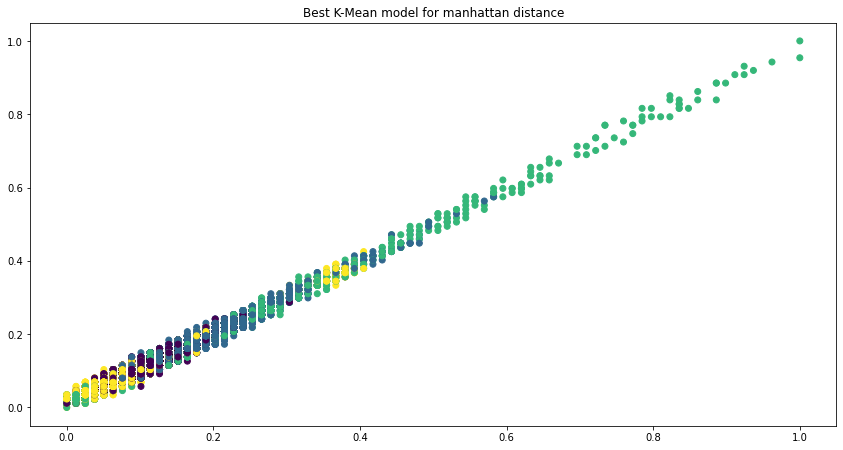

In [57]:
_, L = result_dfs["K-Means results"].loc[4, "Manhattan distance"]
plot_colored_points(X, L, title="Best K-Mean model for manhattan distance")

Best __K-Mean__ model for __chebyshev__ distance

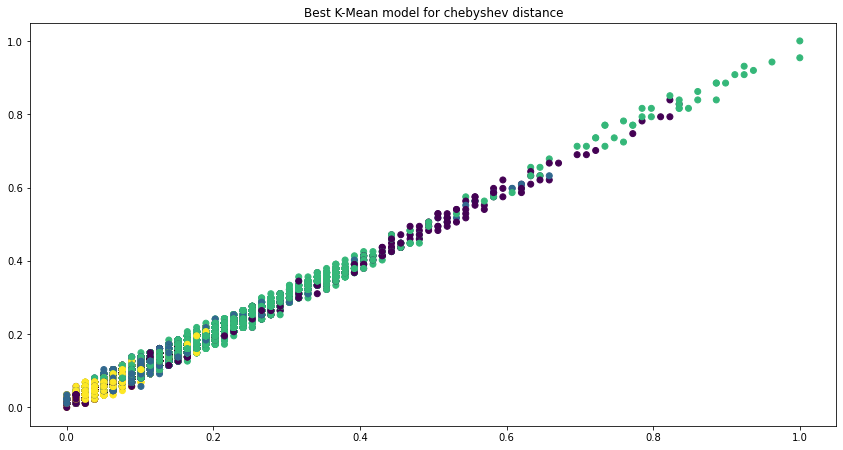

In [58]:
_, L = result_dfs["K-Means results"].loc[4, "Chebyshev distance"]
plot_colored_points(X, L, title="Best K-Mean model for chebyshev distance")

Best __Soft K-Mean__ model for __euclidean__ distance

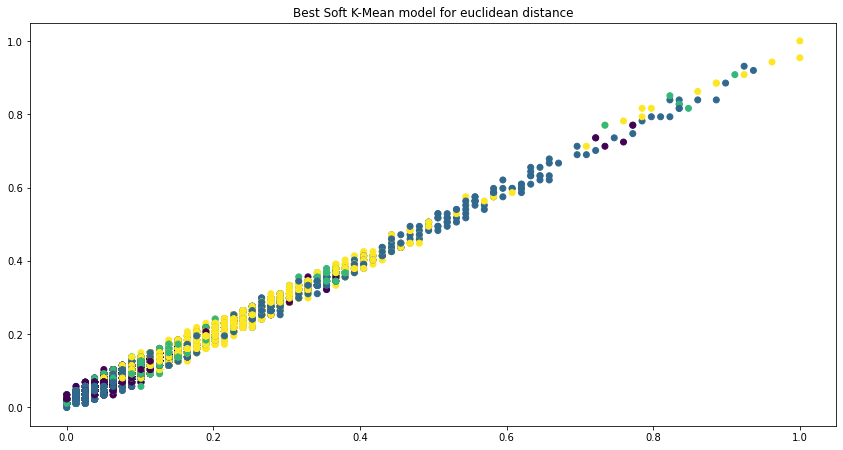

In [59]:
_, R, _ = result_dfs["Soft K-Means results"].loc[4, "Euclidean distance"]
L = np.argmax(R, axis=1)
plot_colored_points(X, L, title="Best Soft K-Mean model for euclidean distance")

Best __Soft K-Mean__ model for __manhattan__ distance

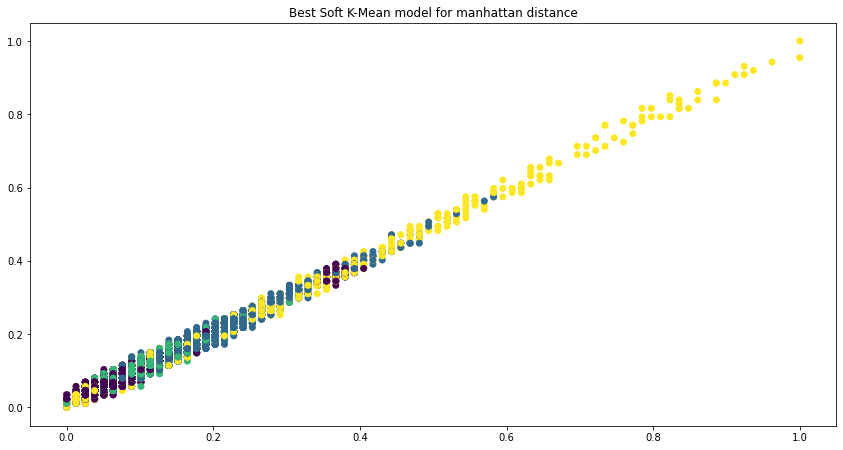

In [60]:
_, R, _ = result_dfs["Soft K-Means results"].loc[4, "Manhattan distance"]
L = np.argmax(R, axis=1)
plot_colored_points(X, L, title="Best Soft K-Mean model for manhattan distance")

Best __Soft K-Mean__ model for __chebyshev__ distance

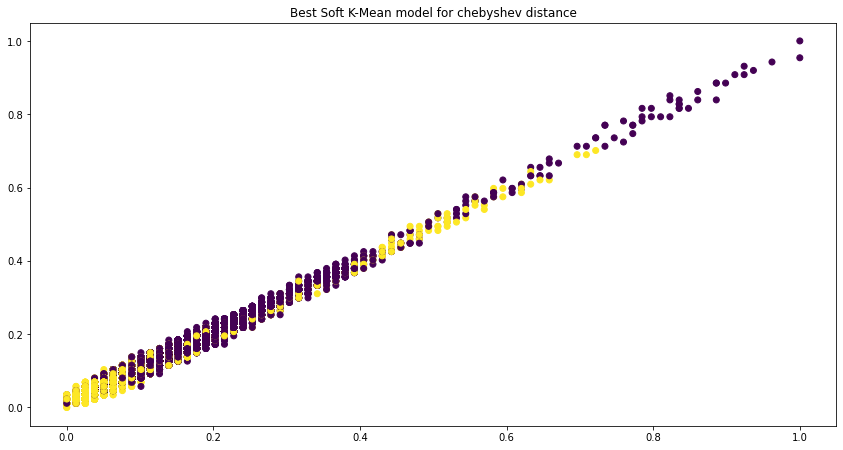

In [61]:
_, R, _ = result_dfs["Soft K-Means results"].loc[4, "Chebyshev distance"]
L = np.argmax(R, axis=1)
plot_colored_points(X, L, title="Best Soft K-Mean model for chebyshev distance")